<a href="https://colab.research.google.com/github/dinhquy-nguyen-1704/NguyenDinhQuy_01/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Đình Quý_Coursework_AI4E'

/content/drive/.shortcut-targets-by-id/1tBK5XJpQsi5a1f_SCa_4sBf7pdjQ5oc6/Đình Quý_Coursework_AI4E


In [ ]:
! pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.8 MB/s eta 0:00:00


In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torch.utils.data as dutils
from facenet_pytorch import MTCNN, InceptionResnetV1
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm

In [ ]:
mtcnn = MTCNN(image_size=160, margin = 0, min_face_size=20) # initializing mtcnn for face detection

In [ ]:
X_train, X_val, X_test = [], [], []
y_train, y_val, y_test = [], [], []
data_folder = "/content/drive/MyDrive/Đình Quý_Coursework_AI4E/Pictures"

for folder in os.listdir(data_folder):
  curr_path = os.path.join(data_folder, folder)
  X_temp = []
  y_temp = []
  for pic_file in os.listdir(curr_path):
    curr_file = os.path.join(curr_path, pic_file)
    X_temp.append(curr_file)
    y_temp.append(folder)

  # for each folder, split the images in it into train, test, split set
  X_train_val_temp, X_test_temp, y_train_val_temp, y_test_temp = train_test_split(X_temp, y_temp, test_size = 0.2, shuffle = True)
  X_train_temp, X_val_temp, y_train_temp, y_val_temp = train_test_split(X_train_val_temp, y_train_val_temp, test_size = 0.375, shuffle = True)

  X_train += X_train_temp
  X_val += X_val_temp
  X_test += X_test_temp

  y_train += y_train_temp
  y_val += y_val_temp
  y_test += y_test_temp

In [ ]:
# Encode label
label_encoder = preprocessing.LabelEncoder()
y_train_encode = label_encoder.fit_transform(y_train)
y_val_encode = label_encoder.transform(y_val)
y_test_encode = label_encoder.transform(y_test)

y_train_encode = torch.Tensor(y_train_encode)
y_val_encode = torch.Tensor(y_val_encode)
y_test_encode = torch.Tensor(y_test_encode)

In [ ]:
print(X_test)

['/content/drive/MyDrive/Đình Quý_Coursework_AI4E/Pictures/Tan/295.png', '/content/drive/MyDrive/Đình Quý_Coursework_AI4E/Pictures/Tan/151.png', '/content/drive/MyDrive/Đình Quý_Coursework_AI4E/Pictures/Tan/220.png', '/content/drive/MyDrive/Đình Quý_Coursework_AI4E/Pictures/Tan/311.png', '/content/drive/MyDrive/Đình Quý_Coursework_AI4E/Pictures/Tan/57.png', '/content/drive/MyDrive/Đình Quý_Coursework_AI4E/Pictures/Tan/301.png', '/content/drive/MyDrive/Đình Quý_Coursework_AI4E/Pictures/Tan/294.png', '/content/drive/MyDrive/Đình Quý_Coursework_AI4E/Pictures/Tan/279.png', '/content/drive/MyDrive/Đình Quý_Coursework_AI4E/Pictures/Tan/111.png', '/content/drive/MyDrive/Đình Quý_Coursework_AI4E/Pictures/Tan/216.png', '/content/drive/MyDrive/Đình Quý_Coursework_AI4E/Pictures/Tan/15.png', '/content/drive/MyDrive/Đình Quý_Coursework_AI4E/Pictures/Tan/211.png', '/content/drive/MyDrive/Đình Quý_Coursework_AI4E/Pictures/Tan/318.png', '/content/drive/MyDrive/Đình Quý_Coursework_AI4E/Pictures/Tan/255

In [ ]:
# Use mtcnn to cut human faces
with torch.no_grad()
  X_train_set = []
  for path in X_train:
    img = Image.open(path)
    face = mtcnn(img, return_prob = False)
    X_train_set.append(face)

  X_val_set = []
  for path in X_val:
    img = Image.open(path)
    face = mtcnn(img, return_prob = False)  
    X_val_set.append(face)

  X_test_set = []
  for path in X_test:
    img = Image.open(path)
    face = mtcnn(img, return_prob = False) 
    X_test_set.append(face)                        

In [ ]:
train_set = list(zip(X_train_set, y_train_encode))
val_set = list(zip(X_val_set, y_val_encode))
test_set = list(zip(X_test_set, y_test_encode))
print(len(train_set))
print(len(val_set))
print(len(test_set))

In [ ]:
train_set = [i for i in train_set if i[0] is not None]
val_set = [i for i in val_set if i[0] is not None]
test_set = [i for i in test_set if i[0] is not None]
print(len(train_set))
print(len(val_set))
print(len(test_set))

In [ ]:
#torch.save(train_set, 'train_set_3.pt')
#torch.save(val_set, 'val_set_3.pt')
#torch.save(test_set, 'test_set_3.pt')

train_set = torch.load('train_set_3.pt')
val_set = torch.load('val_set_3.pt')
test_set = torch.load('test_set_3.pt')

In [ ]:
batch_size = 32
train_loader = dutils.DataLoader(train_set, batch_size = batch_size, shuffle = True, drop_last = True)
val_loader = dutils.DataLoader(val_set, batch_size = batch_size, shuffle = True, drop_last = False)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# freeze_layers function
def freeze_layers(model, freezed_layers):
    child_count = 0
    for child in model.children():
        child_count += 1
        if child_count < (freezed_layers + 1):
            for param in child.parameters():
                param.requires_grad = False
            print("child ", child_count, " was frozen")
    return model

In [ ]:
def train(model, train_loader, val_loader, lr, epochs):
  # Put model on device
  model = model.to(device)
  # Optimization algorithm
  optimizer = optim.Adam(lr = lr, params = model.parameters())

  train_losses = []
  val_losses = []
  val_acc = []

  best_val_loss = 1e100
  best_state_dict = None

  for ei in tqdm(range(epochs)):
    train_lossi = []
    for bi, (xi, yi) in enumerate(train_loader):
      optimizer.zero_grad()
      xi = xi.to(device)
      yi = yi.type(torch.LongTensor) 
      yi = yi.to(device)
      yi_hat = model(xi)
      lossi = lossf(yi_hat, yi)
      lossi.backward()
      optimizer.step()
      train_lossi.append(lossi.item())

    val_lossi = []
    correct = 0.
    total = 0.
    with torch.no_grad():
      for bvi, (xvi, yvi) in enumerate(val_loader):
        xvi = xvi.to(device)
        yvi = yvi.type(torch.LongTensor) 
        yvi = yvi.to(device)
        yvi_hat = model(xvi)
        lossvi = lossf(yvi_hat, yvi)
        val_lossi.append(lossvi.item())
        yvi_hat = yvi_hat.argmax(dim = 1).long()
        yvi = yvi.long()
        correct += (yvi_hat == yvi).sum()
        total += yvi.size(0)
        acci = (correct / total).item()
      val_acc.append(acci)

    train_losses.append(torch.FloatTensor(train_lossi).mean().item())
    val_losses.append(torch.FloatTensor(val_lossi).mean().item())
    if val_losses[-1] < best_val_loss:
      best_val_loss = val_losses[-1]
      best_state_dict = model.state_dict()
    tqdm.write(" train_loss %.4f; val_loss %.4f; val_acc %.4f" % (train_losses[-1], val_losses[-1], val_acc[-1]))
  model.load_state_dict(best_state_dict)  # parameters of model
  return model, train_losses, val_losses, val_acc

In [ ]:
# Define visualize_accuracy function
def visualize_accuracy(val_acc):
    plt.plot(val_acc, color = "green", linewidth = 1)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Valid accuracy')

    plt.show()
    print("="*200)

In [ ]:
# Define visualize_losses function
def visualize_losses(train_losses, val_losses):
    plt.plot(train_losses, color = "green", linewidth = 1)
    plt.plot(val_losses, color = "purple", linestyle = "--", linewidth = 1)
    plt.xlabel('epoch')
    plt.ylabel('losses')
    plt.legend(['Train', 'Valid'])
    plt.title('Train - valid losses')
 
    plt.show()

###VGG16

In [ ]:
# Load VGG16 model
vgg = models.vgg16(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 206MB/s]


In [ ]:
# Freeze layers 1-2 of VGG16
vgg = freeze_layers(vgg, 2)

child  1  was frozen
child  2  was frozen


In [ ]:
# Customize the final layer
vgg.classifier = nn.Sequential(
    nn.Linear(25088, 2048),
    nn.LeakyReLU(),
    nn.Dropout(0.4),
    nn.Linear(2048, 256),
    nn.LeakyReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 14),
    nn.Softmax(dim = 1)
)

In [ ]:
# Define Loss Function
lossf = nn.CrossEntropyLoss()

In [ ]:
lr = 4e-5
epochs = 100
model, train_losses, val_losses, val_acc = train(vgg, train_loader, val_loader, lr = lr, epochs = epochs)

  1%|          | 1/100 [00:22<37:36, 22.80s/it]

 train_loss 2.2825; val_loss 1.9804; val_acc 0.8648


  2%|▏         | 2/100 [00:38<30:04, 18.41s/it]

 train_loss 1.8679; val_loss 1.8223; val_acc 0.9649


  3%|▎         | 3/100 [00:53<27:35, 17.07s/it]

 train_loss 1.8022; val_loss 1.8003; val_acc 0.9701


  4%|▍         | 4/100 [01:09<26:23, 16.49s/it]

 train_loss 1.7879; val_loss 1.7841; val_acc 0.9888


  5%|▌         | 5/100 [01:24<25:41, 16.23s/it]

 train_loss 1.7685; val_loss 1.7699; val_acc 0.9972


  6%|▌         | 6/100 [01:40<25:15, 16.12s/it]

 train_loss 1.7613; val_loss 1.7650; val_acc 0.9977


  7%|▋         | 7/100 [01:56<24:50, 16.02s/it]

 train_loss 1.7586; val_loss 1.7610; val_acc 0.9986


  8%|▊         | 8/100 [02:12<24:25, 15.93s/it]

 train_loss 1.7571; val_loss 1.7608; val_acc 0.9995


  9%|▉         | 9/100 [02:28<24:03, 15.87s/it]

 train_loss 1.7568; val_loss 1.7598; val_acc 0.9986


 10%|█         | 10/100 [02:43<23:43, 15.81s/it]

 train_loss 1.7560; val_loss 1.7584; val_acc 0.9995


 11%|█         | 11/100 [02:59<23:25, 15.80s/it]

 train_loss 1.7559; val_loss 1.7585; val_acc 0.9991


 12%|█▏        | 12/100 [03:15<23:09, 15.79s/it]

 train_loss 1.7557; val_loss 1.7578; val_acc 0.9991


 13%|█▎        | 13/100 [03:31<22:52, 15.77s/it]

 train_loss 1.7555; val_loss 1.7577; val_acc 0.9995


 14%|█▍        | 14/100 [03:46<22:35, 15.76s/it]

 train_loss 1.7557; val_loss 1.7583; val_acc 0.9991


 15%|█▌        | 15/100 [04:02<22:19, 15.75s/it]

 train_loss 1.7556; val_loss 1.7568; val_acc 1.0000


 16%|█▌        | 16/100 [04:18<22:02, 15.75s/it]

 train_loss 1.7554; val_loss 1.7566; val_acc 1.0000


 17%|█▋        | 17/100 [04:34<21:46, 15.74s/it]

 train_loss 1.7552; val_loss 1.7567; val_acc 0.9995


 18%|█▊        | 18/100 [04:49<21:30, 15.74s/it]

 train_loss 1.7551; val_loss 1.7569; val_acc 0.9995


 19%|█▉        | 19/100 [05:05<21:14, 15.73s/it]

 train_loss 1.7551; val_loss 1.7568; val_acc 0.9991


 20%|██        | 20/100 [05:21<20:58, 15.73s/it]

 train_loss 1.7551; val_loss 1.7569; val_acc 0.9995


 21%|██        | 21/100 [05:36<20:42, 15.73s/it]

 train_loss 1.7551; val_loss 1.7563; val_acc 0.9995


 22%|██▏       | 22/100 [05:52<20:27, 15.73s/it]

 train_loss 1.7550; val_loss 1.7566; val_acc 1.0000


 23%|██▎       | 23/100 [06:08<20:11, 15.74s/it]

 train_loss 1.7550; val_loss 1.7564; val_acc 0.9995


 24%|██▍       | 24/100 [06:24<19:56, 15.74s/it]

 train_loss 1.7550; val_loss 1.7565; val_acc 0.9995


 25%|██▌       | 25/100 [06:39<19:40, 15.74s/it]

 train_loss 1.7550; val_loss 1.7557; val_acc 1.0000


 26%|██▌       | 26/100 [06:55<19:24, 15.74s/it]

 train_loss 1.7550; val_loss 1.7560; val_acc 1.0000


 27%|██▋       | 27/100 [07:11<19:09, 15.75s/it]

 train_loss 1.7549; val_loss 1.7556; val_acc 1.0000


 28%|██▊       | 28/100 [07:27<18:53, 15.75s/it]

 train_loss 1.7551; val_loss 1.7559; val_acc 1.0000


 29%|██▉       | 29/100 [07:42<18:37, 15.74s/it]

 train_loss 1.7550; val_loss 1.7558; val_acc 1.0000


 30%|███       | 30/100 [07:58<18:21, 15.74s/it]

 train_loss 1.7550; val_loss 1.7555; val_acc 1.0000


 31%|███       | 31/100 [08:14<18:05, 15.74s/it]

 train_loss 1.7550; val_loss 1.7559; val_acc 1.0000


 32%|███▏      | 32/100 [08:30<17:49, 15.73s/it]

 train_loss 1.7550; val_loss 1.7562; val_acc 0.9991


 33%|███▎      | 33/100 [08:45<17:34, 15.74s/it]

 train_loss 1.7564; val_loss 1.7577; val_acc 0.9986


 34%|███▍      | 34/100 [09:01<17:18, 15.74s/it]

 train_loss 1.7552; val_loss 1.7571; val_acc 0.9991


 35%|███▌      | 35/100 [09:17<17:03, 15.74s/it]

 train_loss 1.7551; val_loss 1.7558; val_acc 1.0000


 36%|███▌      | 36/100 [09:33<16:47, 15.74s/it]

 train_loss 1.7549; val_loss 1.7563; val_acc 0.9995


 37%|███▋      | 37/100 [09:48<16:31, 15.73s/it]

 train_loss 1.7549; val_loss 1.7558; val_acc 1.0000


 38%|███▊      | 38/100 [10:04<16:15, 15.73s/it]

 train_loss 1.7549; val_loss 1.7558; val_acc 0.9995


 39%|███▉      | 39/100 [10:20<15:59, 15.73s/it]

 train_loss 1.7549; val_loss 1.7557; val_acc 0.9995


 40%|████      | 40/100 [10:35<15:43, 15.73s/it]

 train_loss 1.7549; val_loss 1.7560; val_acc 0.9995


 41%|████      | 41/100 [10:51<15:27, 15.73s/it]

 train_loss 1.7568; val_loss 1.7598; val_acc 0.9986


 42%|████▏     | 42/100 [11:07<15:11, 15.72s/it]

 train_loss 1.7553; val_loss 1.7568; val_acc 0.9991


 43%|████▎     | 43/100 [11:23<14:56, 15.72s/it]

 train_loss 1.7549; val_loss 1.7558; val_acc 0.9995


 44%|████▍     | 44/100 [11:38<14:40, 15.73s/it]

 train_loss 1.7549; val_loss 1.7558; val_acc 0.9995


 45%|████▌     | 45/100 [11:54<14:24, 15.72s/it]

 train_loss 1.7563; val_loss 1.7573; val_acc 0.9981


 46%|████▌     | 46/100 [12:10<14:09, 15.73s/it]

 train_loss 1.7550; val_loss 1.7568; val_acc 0.9991


 47%|████▋     | 47/100 [12:26<13:53, 15.73s/it]

 train_loss 1.7549; val_loss 1.7566; val_acc 0.9986


 48%|████▊     | 48/100 [12:41<13:38, 15.73s/it]

 train_loss 1.7549; val_loss 1.7569; val_acc 0.9981


 49%|████▉     | 49/100 [12:57<13:22, 15.73s/it]

 train_loss 1.7549; val_loss 1.7557; val_acc 1.0000


 50%|█████     | 50/100 [13:13<13:06, 15.73s/it]

 train_loss 1.7549; val_loss 1.7558; val_acc 0.9995


 51%|█████     | 51/100 [13:28<12:50, 15.73s/it]

 train_loss 1.7549; val_loss 1.7554; val_acc 1.0000


 52%|█████▏    | 52/100 [13:44<12:35, 15.73s/it]

 train_loss 1.7549; val_loss 1.7554; val_acc 1.0000


 53%|█████▎    | 53/100 [14:00<12:19, 15.73s/it]

 train_loss 1.7549; val_loss 1.7559; val_acc 0.9995


 54%|█████▍    | 54/100 [14:16<12:03, 15.73s/it]

 train_loss 1.7549; val_loss 1.7555; val_acc 0.9995


 55%|█████▌    | 55/100 [14:31<11:48, 15.74s/it]

 train_loss 1.7548; val_loss 1.7556; val_acc 0.9995


 56%|█████▌    | 56/100 [14:47<11:33, 15.75s/it]

 train_loss 1.7548; val_loss 1.7558; val_acc 0.9995


 57%|█████▋    | 57/100 [15:03<11:17, 15.76s/it]

 train_loss 1.7548; val_loss 1.7556; val_acc 0.9995


 58%|█████▊    | 58/100 [15:19<11:01, 15.75s/it]

 train_loss 1.7548; val_loss 1.7552; val_acc 1.0000


 59%|█████▉    | 59/100 [15:34<10:45, 15.74s/it]

 train_loss 1.7548; val_loss 1.7556; val_acc 0.9995


 60%|██████    | 60/100 [15:50<10:28, 15.72s/it]

 train_loss 1.7548; val_loss 1.7557; val_acc 0.9995


 61%|██████    | 61/100 [16:06<10:12, 15.71s/it]

 train_loss 1.7548; val_loss 1.7559; val_acc 0.9995


 62%|██████▏   | 62/100 [16:21<09:56, 15.70s/it]

 train_loss 1.7548; val_loss 1.7554; val_acc 1.0000


 63%|██████▎   | 63/100 [16:37<09:40, 15.70s/it]

 train_loss 1.7548; val_loss 1.7554; val_acc 1.0000


 64%|██████▍   | 64/100 [16:53<09:25, 15.70s/it]

 train_loss 1.7548; val_loss 1.7559; val_acc 0.9991


 65%|██████▌   | 65/100 [17:09<09:09, 15.70s/it]

 train_loss 1.7548; val_loss 1.7552; val_acc 1.0000


 66%|██████▌   | 66/100 [17:24<08:53, 15.69s/it]

 train_loss 1.7548; val_loss 1.7558; val_acc 0.9991


 67%|██████▋   | 67/100 [17:40<08:37, 15.69s/it]

 train_loss 1.7548; val_loss 1.7553; val_acc 0.9995


 68%|██████▊   | 68/100 [17:56<08:22, 15.69s/it]

 train_loss 1.7548; val_loss 1.7561; val_acc 0.9991


 69%|██████▉   | 69/100 [18:11<08:06, 15.70s/it]

 train_loss 1.7548; val_loss 1.7568; val_acc 0.9981


 70%|███████   | 70/100 [18:27<07:50, 15.70s/it]

 train_loss 1.7548; val_loss 1.7550; val_acc 1.0000


 71%|███████   | 71/100 [18:43<07:35, 15.69s/it]

 train_loss 1.7548; val_loss 1.7555; val_acc 0.9995


 72%|███████▏  | 72/100 [18:58<07:19, 15.69s/it]

 train_loss 1.7548; val_loss 1.7550; val_acc 1.0000


 73%|███████▎  | 73/100 [19:14<07:03, 15.70s/it]

 train_loss 1.7548; val_loss 1.7551; val_acc 1.0000


 74%|███████▍  | 74/100 [19:30<06:48, 15.70s/it]

 train_loss 1.7548; val_loss 1.7558; val_acc 0.9995


 75%|███████▌  | 75/100 [19:45<06:32, 15.69s/it]

 train_loss 1.7548; val_loss 1.7556; val_acc 0.9991


 76%|███████▌  | 76/100 [20:01<06:16, 15.69s/it]

 train_loss 1.7548; val_loss 1.7553; val_acc 0.9995


 77%|███████▋  | 77/100 [20:17<06:00, 15.69s/it]

 train_loss 1.7548; val_loss 1.7557; val_acc 0.9991


 78%|███████▊  | 78/100 [20:33<05:45, 15.69s/it]

 train_loss 1.7548; val_loss 1.7562; val_acc 0.9986


 79%|███████▉  | 79/100 [20:48<05:29, 15.69s/it]

 train_loss 1.7548; val_loss 1.7560; val_acc 0.9986


 80%|████████  | 80/100 [21:04<05:13, 15.68s/it]

 train_loss 1.7548; val_loss 1.7553; val_acc 1.0000


 81%|████████  | 81/100 [21:20<04:57, 15.68s/it]

 train_loss 1.7548; val_loss 1.7552; val_acc 1.0000


 82%|████████▏ | 82/100 [21:35<04:42, 15.68s/it]

 train_loss 1.7548; val_loss 1.7552; val_acc 1.0000


 83%|████████▎ | 83/100 [21:51<04:26, 15.68s/it]

 train_loss 1.7548; val_loss 1.7552; val_acc 0.9995


 84%|████████▍ | 84/100 [22:07<04:10, 15.68s/it]

 train_loss 1.7548; val_loss 1.7550; val_acc 1.0000


 85%|████████▌ | 85/100 [22:22<03:55, 15.68s/it]

 train_loss 1.7548; val_loss 1.7552; val_acc 1.0000


 86%|████████▌ | 86/100 [22:38<03:39, 15.68s/it]

 train_loss 1.7548; val_loss 1.7555; val_acc 0.9995


 87%|████████▋ | 87/100 [22:54<03:23, 15.67s/it]

 train_loss 1.7548; val_loss 1.7552; val_acc 1.0000


 88%|████████▊ | 88/100 [23:09<03:08, 15.67s/it]

 train_loss 1.7548; val_loss 1.7555; val_acc 0.9991


 89%|████████▉ | 89/100 [23:25<02:52, 15.67s/it]

 train_loss 1.7553; val_loss 1.7819; val_acc 0.9757


 90%|█████████ | 90/100 [23:41<02:36, 15.68s/it]

 train_loss 1.7612; val_loss 1.7628; val_acc 0.9930


 91%|█████████ | 91/100 [23:56<02:21, 15.68s/it]

 train_loss 1.7579; val_loss 1.7578; val_acc 0.9981


 92%|█████████▏| 92/100 [24:12<02:05, 15.68s/it]

 train_loss 1.7560; val_loss 1.7562; val_acc 0.9991


 93%|█████████▎| 93/100 [24:28<01:49, 15.68s/it]

 train_loss 1.7549; val_loss 1.7557; val_acc 0.9995


 94%|█████████▍| 94/100 [24:43<01:34, 15.68s/it]

 train_loss 1.7548; val_loss 1.7567; val_acc 0.9991


 95%|█████████▌| 95/100 [24:59<01:18, 15.68s/it]

 train_loss 1.7549; val_loss 1.7570; val_acc 0.9972


 96%|█████████▌| 96/100 [25:15<01:02, 15.69s/it]

 train_loss 1.7549; val_loss 1.7557; val_acc 0.9991


 97%|█████████▋| 97/100 [25:30<00:47, 15.68s/it]

 train_loss 1.7549; val_loss 1.7565; val_acc 0.9991


 98%|█████████▊| 98/100 [25:46<00:31, 15.69s/it]

 train_loss 1.7548; val_loss 1.7558; val_acc 0.9991


 99%|█████████▉| 99/100 [26:02<00:15, 15.69s/it]

 train_loss 1.7548; val_loss 1.7555; val_acc 0.9995


100%|██████████| 100/100 [26:18<00:00, 15.78s/it]

 train_loss 1.7548; val_loss 1.7554; val_acc 0.9995


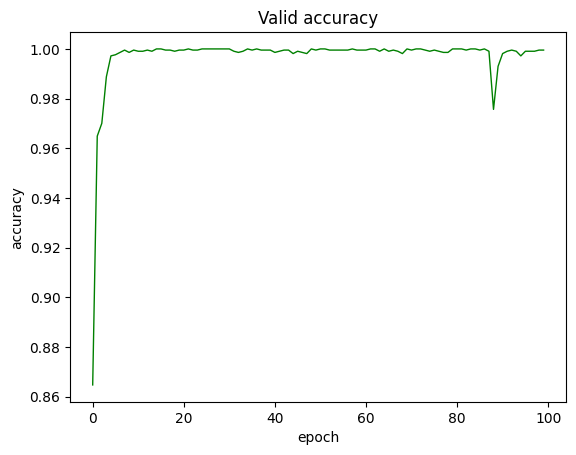

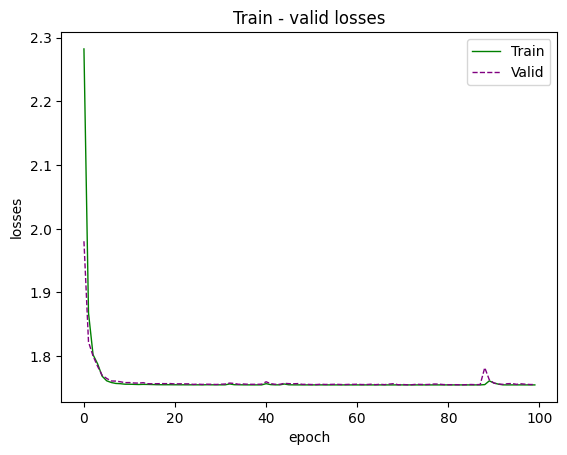

In [ ]:
visualize_accuracy(val_acc)
visualize_losses(train_losses, val_losses)

### DENSENET121

In [ ]:
# Load Densenet-121 model
densenet121 = models.densenet121(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 378MB/s]


In [ ]:
# Freeze first layer of Densenet121
densenet121 = freeze_layers(densenet121, 1)

child  1  was frozen


In [ ]:
# Customize the final layer
densenet121.classifier = nn.Linear(1024, 14)

In [ ]:
# Define Loss function
lossf = nn.CrossEntropyLoss()

In [ ]:
lr = 1e-4
epochs = 100
model, train_losses, val_losses, val_acc = train(densenet121, train_loader, val_loader, lr = lr, epochs = epochs)

  1%|          | 1/100 [00:10<17:40, 10.71s/it]

 train_loss 2.3966; val_loss 2.1199; val_acc 0.4235


  2%|▏         | 2/100 [00:21<17:05, 10.47s/it]

 train_loss 1.9336; val_loss 1.7289; val_acc 0.5957


  3%|▎         | 3/100 [00:31<16:48, 10.39s/it]

 train_loss 1.5888; val_loss 1.4364; val_acc 0.7581


  4%|▍         | 4/100 [00:41<16:34, 10.36s/it]

 train_loss 1.3287; val_loss 1.2129; val_acc 0.8077


  5%|▌         | 5/100 [00:51<16:22, 10.34s/it]

 train_loss 1.1265; val_loss 1.0481; val_acc 0.8535


  6%|▌         | 6/100 [01:02<16:10, 10.33s/it]

 train_loss 0.9764; val_loss 0.9225; val_acc 0.8699


  7%|▋         | 7/100 [01:12<15:59, 10.32s/it]

 train_loss 0.8521; val_loss 0.8159; val_acc 0.9050


  8%|▊         | 8/100 [01:22<15:49, 10.32s/it]

 train_loss 0.7558; val_loss 0.7218; val_acc 0.9233


  9%|▉         | 9/100 [01:33<15:38, 10.32s/it]

 train_loss 0.6744; val_loss 0.6524; val_acc 0.9345


 10%|█         | 10/100 [01:43<15:28, 10.31s/it]

 train_loss 0.6043; val_loss 0.5903; val_acc 0.9490


 11%|█         | 11/100 [01:53<15:17, 10.31s/it]

 train_loss 0.5540; val_loss 0.5426; val_acc 0.9490


 12%|█▏        | 12/100 [02:04<15:07, 10.31s/it]

 train_loss 0.4998; val_loss 0.4974; val_acc 0.9560


 13%|█▎        | 13/100 [02:14<14:57, 10.31s/it]

 train_loss 0.4548; val_loss 0.4660; val_acc 0.9616


 14%|█▍        | 14/100 [02:24<14:46, 10.31s/it]

 train_loss 0.4249; val_loss 0.4326; val_acc 0.9616


 15%|█▌        | 15/100 [02:35<14:40, 10.35s/it]

 train_loss 0.3904; val_loss 0.4066; val_acc 0.9663


 16%|█▌        | 16/100 [02:45<14:28, 10.34s/it]

 train_loss 0.3617; val_loss 0.3719; val_acc 0.9724


 17%|█▋        | 17/100 [02:55<14:17, 10.33s/it]

 train_loss 0.3349; val_loss 0.3560; val_acc 0.9691


 18%|█▊        | 18/100 [03:06<14:06, 10.32s/it]

 train_loss 0.3125; val_loss 0.3288; val_acc 0.9747


 19%|█▉        | 19/100 [03:16<13:55, 10.32s/it]

 train_loss 0.2944; val_loss 0.3108; val_acc 0.9766


 20%|██        | 20/100 [03:26<13:44, 10.31s/it]

 train_loss 0.2759; val_loss 0.2992; val_acc 0.9780


 21%|██        | 21/100 [03:36<13:34, 10.31s/it]

 train_loss 0.2612; val_loss 0.2801; val_acc 0.9733


 22%|██▏       | 22/100 [03:47<13:23, 10.31s/it]

 train_loss 0.2472; val_loss 0.2666; val_acc 0.9789


 23%|██▎       | 23/100 [03:57<13:13, 10.30s/it]

 train_loss 0.2335; val_loss 0.2542; val_acc 0.9780


 24%|██▍       | 24/100 [04:07<13:02, 10.30s/it]

 train_loss 0.2163; val_loss 0.2356; val_acc 0.9808


 25%|██▌       | 25/100 [04:18<12:52, 10.30s/it]

 train_loss 0.2004; val_loss 0.2257; val_acc 0.9813


 26%|██▌       | 26/100 [04:28<12:42, 10.30s/it]

 train_loss 0.1953; val_loss 0.2232; val_acc 0.9813


 27%|██▋       | 27/100 [04:38<12:31, 10.30s/it]

 train_loss 0.1814; val_loss 0.2114; val_acc 0.9766


 28%|██▊       | 28/100 [04:49<12:22, 10.31s/it]

 train_loss 0.1765; val_loss 0.2000; val_acc 0.9836


 29%|██▉       | 29/100 [04:59<12:12, 10.31s/it]

 train_loss 0.1661; val_loss 0.1941; val_acc 0.9822


 30%|███       | 30/100 [05:09<12:02, 10.32s/it]

 train_loss 0.1591; val_loss 0.1812; val_acc 0.9841


 31%|███       | 31/100 [05:20<11:52, 10.33s/it]

 train_loss 0.1520; val_loss 0.1788; val_acc 0.9864


 32%|███▏      | 32/100 [05:30<11:42, 10.32s/it]

 train_loss 0.1421; val_loss 0.1674; val_acc 0.9888


 33%|███▎      | 33/100 [05:40<11:31, 10.32s/it]

 train_loss 0.1416; val_loss 0.1626; val_acc 0.9832


 34%|███▍      | 34/100 [05:51<11:21, 10.32s/it]

 train_loss 0.1323; val_loss 0.1576; val_acc 0.9860


 35%|███▌      | 35/100 [06:01<11:11, 10.32s/it]

 train_loss 0.1268; val_loss 0.1588; val_acc 0.9827


 36%|███▌      | 36/100 [06:11<11:01, 10.33s/it]

 train_loss 0.1207; val_loss 0.1480; val_acc 0.9869


 37%|███▋      | 37/100 [06:22<10:50, 10.33s/it]

 train_loss 0.1174; val_loss 0.1399; val_acc 0.9892


 38%|███▊      | 38/100 [06:32<10:40, 10.33s/it]

 train_loss 0.1109; val_loss 0.1355; val_acc 0.9878


 39%|███▉      | 39/100 [06:42<10:29, 10.32s/it]

 train_loss 0.1073; val_loss 0.1358; val_acc 0.9864


 40%|████      | 40/100 [06:53<10:18, 10.31s/it]

 train_loss 0.1026; val_loss 0.1280; val_acc 0.9878


 41%|████      | 41/100 [07:03<10:08, 10.31s/it]

 train_loss 0.0995; val_loss 0.1228; val_acc 0.9883


 42%|████▏     | 42/100 [07:13<09:57, 10.31s/it]

 train_loss 0.0922; val_loss 0.1196; val_acc 0.9911


 43%|████▎     | 43/100 [07:23<09:47, 10.31s/it]

 train_loss 0.0915; val_loss 0.1164; val_acc 0.9892


 44%|████▍     | 44/100 [07:34<09:37, 10.31s/it]

 train_loss 0.0886; val_loss 0.1094; val_acc 0.9911


 45%|████▌     | 45/100 [07:44<09:26, 10.31s/it]

 train_loss 0.0836; val_loss 0.1137; val_acc 0.9860


 46%|████▌     | 46/100 [07:54<09:16, 10.31s/it]

 train_loss 0.0838; val_loss 0.1052; val_acc 0.9911


 47%|████▋     | 47/100 [08:05<09:06, 10.31s/it]

 train_loss 0.0791; val_loss 0.1054; val_acc 0.9906


 48%|████▊     | 48/100 [08:15<08:55, 10.30s/it]

 train_loss 0.0755; val_loss 0.1036; val_acc 0.9911


 49%|████▉     | 49/100 [08:25<08:45, 10.31s/it]

 train_loss 0.0747; val_loss 0.1011; val_acc 0.9911


 50%|█████     | 50/100 [08:36<08:35, 10.31s/it]

 train_loss 0.0707; val_loss 0.0969; val_acc 0.9897


 51%|█████     | 51/100 [08:46<08:25, 10.31s/it]

 train_loss 0.0674; val_loss 0.0954; val_acc 0.9874


 52%|█████▏    | 52/100 [08:56<08:14, 10.30s/it]

 train_loss 0.0675; val_loss 0.0956; val_acc 0.9892


 53%|█████▎    | 53/100 [09:06<08:04, 10.30s/it]

 train_loss 0.0616; val_loss 0.0960; val_acc 0.9883


 54%|█████▍    | 54/100 [09:17<07:53, 10.30s/it]

 train_loss 0.0594; val_loss 0.0884; val_acc 0.9902


 55%|█████▌    | 55/100 [09:27<07:43, 10.30s/it]

 train_loss 0.0591; val_loss 0.0809; val_acc 0.9925


 56%|█████▌    | 56/100 [09:37<07:33, 10.30s/it]

 train_loss 0.0590; val_loss 0.0804; val_acc 0.9930


 57%|█████▋    | 57/100 [09:48<07:23, 10.30s/it]

 train_loss 0.0539; val_loss 0.0787; val_acc 0.9934


 58%|█████▊    | 58/100 [09:58<07:12, 10.30s/it]

 train_loss 0.0549; val_loss 0.0801; val_acc 0.9911


 59%|█████▉    | 59/100 [10:08<07:02, 10.30s/it]

 train_loss 0.0508; val_loss 0.0805; val_acc 0.9883


 60%|██████    | 60/100 [10:19<06:51, 10.30s/it]

 train_loss 0.0492; val_loss 0.0775; val_acc 0.9906


 61%|██████    | 61/100 [10:29<06:41, 10.30s/it]

 train_loss 0.0478; val_loss 0.0773; val_acc 0.9911


 62%|██████▏   | 62/100 [10:39<06:31, 10.30s/it]

 train_loss 0.0478; val_loss 0.0744; val_acc 0.9911


 63%|██████▎   | 63/100 [10:49<06:21, 10.30s/it]

 train_loss 0.0464; val_loss 0.0703; val_acc 0.9911


 64%|██████▍   | 64/100 [11:00<06:10, 10.30s/it]

 train_loss 0.0450; val_loss 0.0706; val_acc 0.9930


 65%|██████▌   | 65/100 [11:10<06:00, 10.30s/it]

 train_loss 0.0441; val_loss 0.0644; val_acc 0.9944


 66%|██████▌   | 66/100 [11:20<05:50, 10.30s/it]

 train_loss 0.0409; val_loss 0.0643; val_acc 0.9920


 67%|██████▋   | 67/100 [11:31<05:39, 10.30s/it]

 train_loss 0.0383; val_loss 0.0610; val_acc 0.9939


 68%|██████▊   | 68/100 [11:41<05:29, 10.30s/it]

 train_loss 0.0383; val_loss 0.0599; val_acc 0.9953


 69%|██████▉   | 69/100 [11:51<05:19, 10.30s/it]

 train_loss 0.0386; val_loss 0.0628; val_acc 0.9953


 70%|███████   | 70/100 [12:02<05:09, 10.30s/it]

 train_loss 0.0362; val_loss 0.0573; val_acc 0.9949


 71%|███████   | 71/100 [12:12<04:58, 10.30s/it]

 train_loss 0.0353; val_loss 0.0588; val_acc 0.9939


 72%|███████▏  | 72/100 [12:22<04:48, 10.30s/it]

 train_loss 0.0360; val_loss 0.0591; val_acc 0.9930


 73%|███████▎  | 73/100 [12:33<04:38, 10.31s/it]

 train_loss 0.0325; val_loss 0.0548; val_acc 0.9930


 74%|███████▍  | 74/100 [12:43<04:27, 10.30s/it]

 train_loss 0.0329; val_loss 0.0552; val_acc 0.9939


 75%|███████▌  | 75/100 [12:53<04:17, 10.30s/it]

 train_loss 0.0323; val_loss 0.0581; val_acc 0.9916


 76%|███████▌  | 76/100 [13:03<04:07, 10.30s/it]

 train_loss 0.0301; val_loss 0.0589; val_acc 0.9911


 77%|███████▋  | 77/100 [13:14<03:56, 10.30s/it]

 train_loss 0.0295; val_loss 0.0524; val_acc 0.9939


 78%|███████▊  | 78/100 [13:24<03:46, 10.30s/it]

 train_loss 0.0291; val_loss 0.0533; val_acc 0.9939


 79%|███████▉  | 79/100 [13:34<03:36, 10.31s/it]

 train_loss 0.0288; val_loss 0.0478; val_acc 0.9939


 80%|████████  | 80/100 [13:45<03:26, 10.30s/it]

 train_loss 0.0261; val_loss 0.0521; val_acc 0.9949


 81%|████████  | 81/100 [13:55<03:15, 10.30s/it]

 train_loss 0.0280; val_loss 0.0523; val_acc 0.9920


 82%|████████▏ | 82/100 [14:05<03:05, 10.30s/it]

 train_loss 0.0279; val_loss 0.0475; val_acc 0.9953


 83%|████████▎ | 83/100 [14:16<02:55, 10.31s/it]

 train_loss 0.0243; val_loss 0.0486; val_acc 0.9934


 84%|████████▍ | 84/100 [14:26<02:45, 10.31s/it]

 train_loss 0.0238; val_loss 0.0450; val_acc 0.9953


 85%|████████▌ | 85/100 [14:36<02:34, 10.31s/it]

 train_loss 0.0240; val_loss 0.0481; val_acc 0.9916


 86%|████████▌ | 86/100 [14:46<02:24, 10.30s/it]

 train_loss 0.0232; val_loss 0.0469; val_acc 0.9939


 87%|████████▋ | 87/100 [14:57<02:13, 10.30s/it]

 train_loss 0.0242; val_loss 0.0458; val_acc 0.9958


 88%|████████▊ | 88/100 [15:07<02:03, 10.31s/it]

 train_loss 0.0223; val_loss 0.0445; val_acc 0.9934


 89%|████████▉ | 89/100 [15:17<01:53, 10.31s/it]

 train_loss 0.0220; val_loss 0.0404; val_acc 0.9963


 90%|█████████ | 90/100 [15:28<01:43, 10.30s/it]

 train_loss 0.0209; val_loss 0.0449; val_acc 0.9925


 91%|█████████ | 91/100 [15:38<01:32, 10.30s/it]

 train_loss 0.0190; val_loss 0.0423; val_acc 0.9939


 92%|█████████▏| 92/100 [15:48<01:22, 10.30s/it]

 train_loss 0.0194; val_loss 0.0427; val_acc 0.9963


 93%|█████████▎| 93/100 [15:59<01:12, 10.31s/it]

 train_loss 0.0180; val_loss 0.0381; val_acc 0.9958


 94%|█████████▍| 94/100 [16:09<01:01, 10.30s/it]

 train_loss 0.0188; val_loss 0.0393; val_acc 0.9949


 95%|█████████▌| 95/100 [16:19<00:51, 10.31s/it]

 train_loss 0.0189; val_loss 0.0376; val_acc 0.9967


 96%|█████████▌| 96/100 [16:30<00:41, 10.31s/it]

 train_loss 0.0189; val_loss 0.0392; val_acc 0.9934


 97%|█████████▋| 97/100 [16:40<00:30, 10.30s/it]

 train_loss 0.0175; val_loss 0.0431; val_acc 0.9920


 98%|█████████▊| 98/100 [16:50<00:20, 10.30s/it]

 train_loss 0.0185; val_loss 0.0349; val_acc 0.9953


 99%|█████████▉| 99/100 [17:00<00:10, 10.30s/it]

 train_loss 0.0177; val_loss 0.0374; val_acc 0.9939


100%|██████████| 100/100 [17:11<00:00, 10.31s/it]

 train_loss 0.0162; val_loss 0.0375; val_acc 0.9939


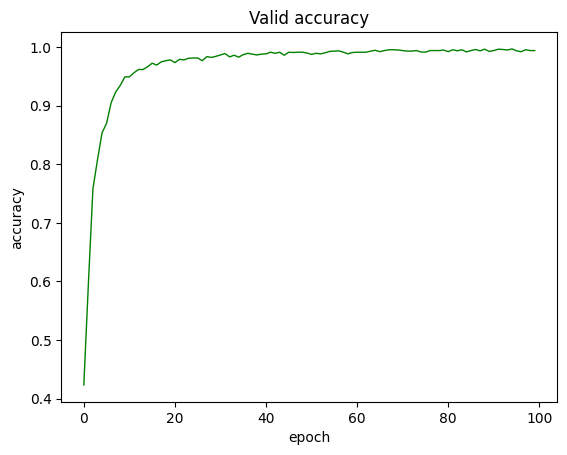

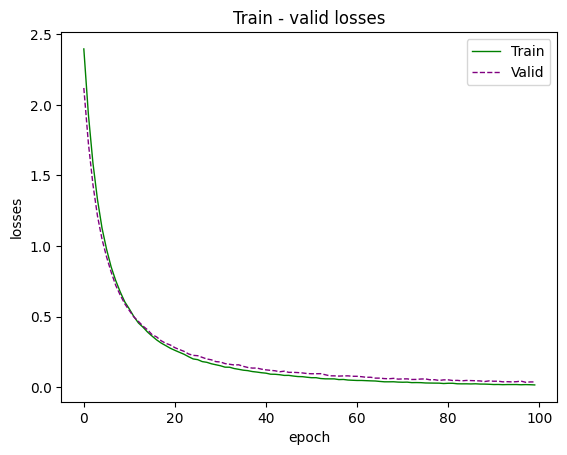

In [ ]:
visualize_accuracy(val_acc)
visualize_losses(train_losses, val_losses)

###RESNET50

In [ ]:
# Load Resnet50 model
resnet = models.resnet50(pretrained = True)
print(resnet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 337MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Freeze layer 1-6 of Resnet50
resnet = freeze_layers(resnet, 6)

child  1  was frozen
child  2  was frozen
child  3  was frozen
child  4  was frozen
child  5  was frozen
child  6  was frozen


In [ ]:
# Customize the final layer of Resnet50
resnet.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, 256),
    nn.LeakyReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 14),
    nn.LogSoftmax(dim = 1)
)

In [ ]:
# Define Loss function
lossf = nn.NLLLoss()

In [ ]:
lr = 1e-5
epochs = 100
model, train_losses, val_losses, val_acc = train(resnet, train_loader, val_loader, lr = lr, epochs = epochs)

  1%|          | 1/100 [00:16<27:11, 16.48s/it]

 train_loss 0.0001; val_loss 0.0001; val_acc 1.0000


  2%|▏         | 2/100 [00:33<27:05, 16.59s/it]

 train_loss 0.0003; val_loss 0.0052; val_acc 0.9995


  3%|▎         | 3/100 [00:50<27:01, 16.72s/it]

 train_loss 0.0001; val_loss 0.0015; val_acc 0.9995


  4%|▍         | 4/100 [01:06<26:28, 16.55s/it]

 train_loss 0.0000; val_loss 0.0002; val_acc 1.0000


  5%|▌         | 5/100 [01:22<26:02, 16.45s/it]

 train_loss 0.0018; val_loss 0.0004; val_acc 1.0000


  6%|▌         | 6/100 [01:38<25:43, 16.42s/it]

 train_loss 0.0000; val_loss 0.0048; val_acc 0.9991


  7%|▋         | 7/100 [01:55<25:26, 16.41s/it]

 train_loss 0.0000; val_loss 0.0005; val_acc 1.0000


  8%|▊         | 8/100 [02:11<25:09, 16.41s/it]

 train_loss 0.0000; val_loss 0.0010; val_acc 0.9995


  9%|▉         | 9/100 [02:28<24:52, 16.40s/it]

 train_loss 0.0000; val_loss 0.0002; val_acc 1.0000


 10%|█         | 10/100 [02:44<24:34, 16.38s/it]

 train_loss 0.0000; val_loss 0.0002; val_acc 1.0000


 11%|█         | 11/100 [03:00<24:17, 16.37s/it]

 train_loss 0.0001; val_loss 0.0001; val_acc 1.0000


 12%|█▏        | 12/100 [03:17<24:00, 16.37s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 13%|█▎        | 13/100 [03:33<23:43, 16.36s/it]

 train_loss 0.0000; val_loss 0.0004; val_acc 1.0000


 14%|█▍        | 14/100 [03:49<23:27, 16.37s/it]

 train_loss 0.0000; val_loss 0.0007; val_acc 0.9995


 15%|█▌        | 15/100 [04:06<23:11, 16.37s/it]

 train_loss 0.0001; val_loss 0.0001; val_acc 1.0000


 16%|█▌        | 16/100 [04:22<22:55, 16.37s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 17%|█▋        | 17/100 [04:39<22:39, 16.37s/it]

 train_loss 0.0000; val_loss 0.0002; val_acc 1.0000


 18%|█▊        | 18/100 [04:55<22:22, 16.38s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 19%|█▉        | 19/100 [05:11<22:06, 16.37s/it]

 train_loss 0.0000; val_loss 0.0038; val_acc 0.9986


 20%|██        | 20/100 [05:28<21:49, 16.37s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 21%|██        | 21/100 [05:44<21:33, 16.37s/it]

 train_loss 0.0000; val_loss 0.0003; val_acc 1.0000


 22%|██▏       | 22/100 [06:00<21:17, 16.38s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 23%|██▎       | 23/100 [06:17<21:00, 16.38s/it]

 train_loss 0.0000; val_loss 0.0005; val_acc 0.9995


 24%|██▍       | 24/100 [06:33<20:43, 16.37s/it]

 train_loss 0.0000; val_loss 0.0004; val_acc 1.0000


 25%|██▌       | 25/100 [06:49<20:27, 16.36s/it]

 train_loss 0.0000; val_loss 0.0013; val_acc 0.9991


 26%|██▌       | 26/100 [07:06<20:10, 16.36s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 27%|██▋       | 27/100 [07:22<19:54, 16.36s/it]

 train_loss 0.0015; val_loss 0.0017; val_acc 0.9995


 28%|██▊       | 28/100 [07:39<19:37, 16.35s/it]

 train_loss 0.0029; val_loss 0.0009; val_acc 1.0000


 29%|██▉       | 29/100 [07:55<19:20, 16.34s/it]

 train_loss 0.0013; val_loss 0.0046; val_acc 0.9986


 30%|███       | 30/100 [08:11<19:03, 16.34s/it]

 train_loss 0.0002; val_loss 0.0011; val_acc 0.9995


 31%|███       | 31/100 [08:28<18:47, 16.35s/it]

 train_loss 0.0001; val_loss 0.0022; val_acc 0.9991


 32%|███▏      | 32/100 [08:44<18:31, 16.35s/it]

 train_loss 0.0001; val_loss 0.0006; val_acc 1.0000


 33%|███▎      | 33/100 [09:00<18:15, 16.35s/it]

 train_loss 0.0008; val_loss 0.0003; val_acc 1.0000


 34%|███▍      | 34/100 [09:17<17:59, 16.35s/it]

 train_loss 0.0001; val_loss 0.0005; val_acc 0.9995


 35%|███▌      | 35/100 [09:33<17:43, 16.36s/it]

 train_loss 0.0001; val_loss 0.0015; val_acc 0.9995


 36%|███▌      | 36/100 [09:49<17:27, 16.36s/it]

 train_loss 0.0002; val_loss 0.0043; val_acc 0.9991


 37%|███▋      | 37/100 [10:06<17:10, 16.36s/it]

 train_loss 0.0001; val_loss 0.0002; val_acc 1.0000


 38%|███▊      | 38/100 [10:22<16:54, 16.37s/it]

 train_loss 0.0000; val_loss 0.0013; val_acc 0.9995


 39%|███▉      | 39/100 [10:38<16:38, 16.37s/it]

 train_loss 0.0001; val_loss 0.0006; val_acc 0.9995


 40%|████      | 40/100 [10:55<16:22, 16.37s/it]

 train_loss 0.0000; val_loss 0.0012; val_acc 0.9991


 41%|████      | 41/100 [11:11<16:05, 16.37s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 42%|████▏     | 42/100 [11:28<15:49, 16.36s/it]

 train_loss 0.0000; val_loss 0.0002; val_acc 1.0000


 43%|████▎     | 43/100 [11:44<15:32, 16.36s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 44%|████▍     | 44/100 [12:00<15:16, 16.36s/it]

 train_loss 0.0000; val_loss 0.0002; val_acc 1.0000


 45%|████▌     | 45/100 [12:17<14:59, 16.35s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 46%|████▌     | 46/100 [12:33<14:42, 16.35s/it]

 train_loss 0.0000; val_loss 0.0005; val_acc 0.9995


 47%|████▋     | 47/100 [12:49<14:26, 16.35s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 48%|████▊     | 48/100 [13:06<14:10, 16.35s/it]

 train_loss 0.0000; val_loss 0.0014; val_acc 0.9995


 49%|████▉     | 49/100 [13:22<13:53, 16.35s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 50%|█████     | 50/100 [13:38<13:37, 16.36s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 51%|█████     | 51/100 [13:55<13:21, 16.36s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 52%|█████▏    | 52/100 [14:11<13:05, 16.36s/it]

 train_loss 0.0000; val_loss 0.0007; val_acc 0.9995


 53%|█████▎    | 53/100 [14:27<12:49, 16.37s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 54%|█████▍    | 54/100 [14:44<12:33, 16.37s/it]

 train_loss 0.0000; val_loss 0.0004; val_acc 1.0000


 55%|█████▌    | 55/100 [15:00<12:17, 16.38s/it]

 train_loss 0.0000; val_loss 0.0022; val_acc 0.9995


 56%|█████▌    | 56/100 [15:17<12:00, 16.38s/it]

 train_loss 0.0000; val_loss 0.0005; val_acc 1.0000


 57%|█████▋    | 57/100 [15:33<11:44, 16.38s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 58%|█████▊    | 58/100 [15:49<11:27, 16.37s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 59%|█████▉    | 59/100 [16:06<11:11, 16.38s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 60%|██████    | 60/100 [16:22<10:55, 16.38s/it]

 train_loss 0.0000; val_loss 0.0003; val_acc 1.0000


 61%|██████    | 61/100 [16:39<10:39, 16.39s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 62%|██████▏   | 62/100 [16:55<10:22, 16.39s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 63%|██████▎   | 63/100 [17:11<10:06, 16.39s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 64%|██████▍   | 64/100 [17:28<09:49, 16.38s/it]

 train_loss 0.0000; val_loss 0.0005; val_acc 0.9995


 65%|██████▌   | 65/100 [17:44<09:32, 16.37s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 66%|██████▌   | 66/100 [18:00<09:16, 16.37s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 67%|██████▋   | 67/100 [18:17<09:00, 16.37s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 68%|██████▊   | 68/100 [18:33<08:43, 16.37s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 69%|██████▉   | 69/100 [18:49<08:27, 16.36s/it]

 train_loss 0.0000; val_loss 0.0004; val_acc 1.0000


 70%|███████   | 70/100 [19:06<08:10, 16.36s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 71%|███████   | 71/100 [19:22<07:54, 16.35s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 72%|███████▏  | 72/100 [19:39<07:37, 16.35s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 73%|███████▎  | 73/100 [19:55<07:21, 16.35s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 74%|███████▍  | 74/100 [20:11<07:05, 16.35s/it]

 train_loss 0.0000; val_loss 0.0005; val_acc 0.9995


 75%|███████▌  | 75/100 [20:28<06:48, 16.35s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 76%|███████▌  | 76/100 [20:44<06:32, 16.35s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 77%|███████▋  | 77/100 [21:00<06:16, 16.35s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 78%|███████▊  | 78/100 [21:17<05:59, 16.36s/it]

 train_loss 0.0000; val_loss 0.0008; val_acc 0.9991


 79%|███████▉  | 79/100 [21:33<05:43, 16.36s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 80%|████████  | 80/100 [21:49<05:27, 16.36s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 81%|████████  | 81/100 [22:06<05:10, 16.35s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 82%|████████▏ | 82/100 [22:22<04:54, 16.35s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 83%|████████▎ | 83/100 [22:38<04:38, 16.36s/it]

 train_loss 0.0000; val_loss 0.0060; val_acc 0.9986


 84%|████████▍ | 84/100 [22:55<04:21, 16.36s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 85%|████████▌ | 85/100 [23:11<04:05, 16.36s/it]

 train_loss 0.0000; val_loss 0.0002; val_acc 1.0000


 86%|████████▌ | 86/100 [23:28<03:49, 16.36s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 87%|████████▋ | 87/100 [23:44<03:32, 16.37s/it]

 train_loss 0.0020; val_loss 0.0274; val_acc 0.9944


 88%|████████▊ | 88/100 [24:00<03:16, 16.37s/it]

 train_loss 0.0002; val_loss 0.0005; val_acc 1.0000


 89%|████████▉ | 89/100 [24:17<03:00, 16.37s/it]

 train_loss 0.0000; val_loss 0.0014; val_acc 0.9991


 90%|█████████ | 90/100 [24:33<02:43, 16.37s/it]

 train_loss 0.0001; val_loss 0.0035; val_acc 0.9991


 91%|█████████ | 91/100 [24:49<02:27, 16.37s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 92%|█████████▏| 92/100 [25:06<02:11, 16.38s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 93%|█████████▎| 93/100 [25:22<01:54, 16.37s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 94%|█████████▍| 94/100 [25:38<01:38, 16.37s/it]

 train_loss 0.0000; val_loss 0.0004; val_acc 1.0000


 95%|█████████▌| 95/100 [25:55<01:21, 16.37s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 96%|█████████▌| 96/100 [26:11<01:05, 16.37s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 97%|█████████▋| 97/100 [26:28<00:49, 16.37s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


 98%|█████████▊| 98/100 [26:44<00:32, 16.37s/it]

 train_loss 0.0000; val_loss 0.0001; val_acc 1.0000


 99%|█████████▉| 99/100 [27:00<00:16, 16.37s/it]

 train_loss 0.0000; val_loss 0.0000; val_acc 1.0000


100%|██████████| 100/100 [27:17<00:00, 16.37s/it]

 train_loss 0.0000; val_loss 0.0002; val_acc 1.0000


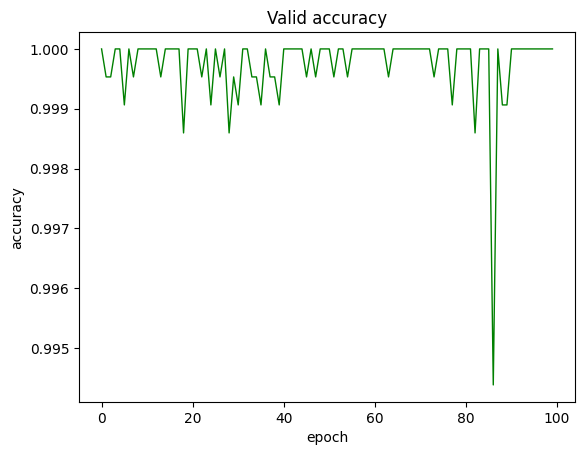

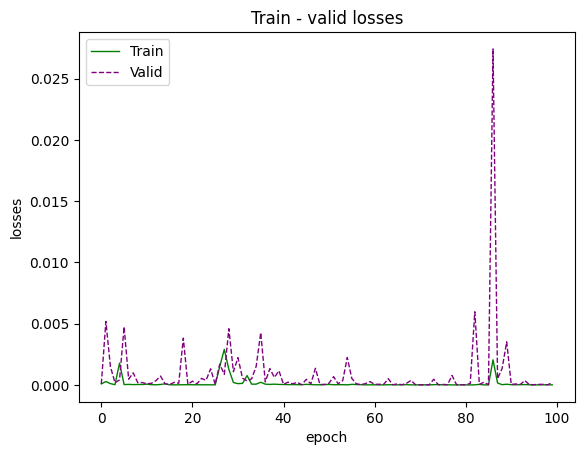

In [ ]:
visualize_accuracy(val_acc)
visualize_losses(train_losses, val_losses)

### TEST CASE (WITH RESNET)

In [ ]:
# Define test_case function
def test_case(picture_path):
  img = Image.open(picture_path)
  face, prob = mtcnn(img, return_prob = True)
  if face is not None and prob > 0.90:
    face = face.to(device)
    recognition = model(face.unsqueeze(0))
    recognition = recognition.argmax(dim = 1).long()
    name = label_encoder.inverse_transform(recognition.cpu())
    print(name[0])
  else:
    print("unrecognizable")

In [ ]:
picture_path = "/content/drive/MyDrive/Đình Quý_Coursework_AI4E/Pictures/Tan/151.png"
test_case(picture_path)

Xuan_Anh
